# Detect pair trading opportunities using ML (clustering) and statistical methods

Traders who are particuarly keen on Pairs Trading, need a way to find pairs that:
    
    a) Are similar in risk and behaviour
    b) Are cointegrated

I will use K-means clustering to group etfs with similar annual return and volatility. 
Then I have cointegration calculations run against them to further help with statistical methods.

### Imports

In [49]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

### Data Extraction

In [46]:
# Set Data Extraction parameters
start_date = "2018-01-01"
end_date = "2022-12-30"

In [50]:
# Get New or Load Existing Data
# Allow 15 mins for new data
symbols = get_nasdaq_symbols()
symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
symbols = list(symbols.index.values)
data = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

[*********************100%***********************]  525 of 525 completed

1 Failed download:
- COWG: Data doesn't exist for startDate = 1514782800, endDate = 1672376400


In [53]:
# Load (or re-load for consistency) Data and remove features with NaN's
data.dropna(axis=1, inplace=True)
#data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (1258, 296)
Null Values:  False


,AADR,AAXJ,ACWI,ACWX,ADRE,AGNG,AGZD,AIA,AIRR,ALTY,...,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,56.889935,73.799957,66.106606,44.308975,39.731728,19.549788,40.452728,61.156921,27.267223,10.201028,...,41.240112,131.992050,57.915672,100.378372,64.143227,49.542725,55.418861,65.997955,33.978573,25.506401
2018-01-03 00:00:00,57.484306,74.444336,66.442741,44.589745,39.839016,19.839891,40.318661,61.800301,27.277138,10.261153,...,41.248566,132.940491,57.971981,100.396645,64.207054,49.888096,55.676865,66.263123,34.252975,25.607622
2018-01-04 00:00:00,57.701294,74.567520,66.906036,44.923161,39.955238,19.719267,40.419201,62.035908,27.435722,10.267834,...,41.257019,133.298615,58.136169,100.624840,64.215027,50.302532,56.246117,66.189987,34.385445,25.607622
2018-01-05 00:00:00,58.154148,75.249809,67.342072,45.247795,40.411198,19.887747,40.427574,62.452728,27.247400,10.280525,...,41.248566,133.647018,58.314445,100.789162,64.302788,50.639267,56.516422,66.574005,34.669300,25.607622
2018-01-08 00:00:00,58.154148,75.325623,67.405678,45.247795,40.679420,19.828928,40.511395,62.470856,27.316782,10.294556,...,41.240112,133.579300,58.375443,101.163422,64.151222,50.613365,56.393559,66.912315,34.707153,25.607622


### Feature Engineering

In [54]:
# Create DataFrame with Returns and Volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,-0.005042,0.245257
AAXJ,0.002915,0.229540
ACWI,0.073187,0.205478
ACWX,0.028246,0.202087
ADRE,0.024983,0.266524


In [55]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,-1.001303,0.258863
AAXJ,-0.874219,0.108567
ACWI,0.248022,-0.121526
ACWX,-0.469682,-0.153956
ADRE,-0.521789,0.462228


### K-Means Clustering

In [56]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  5


In [57]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

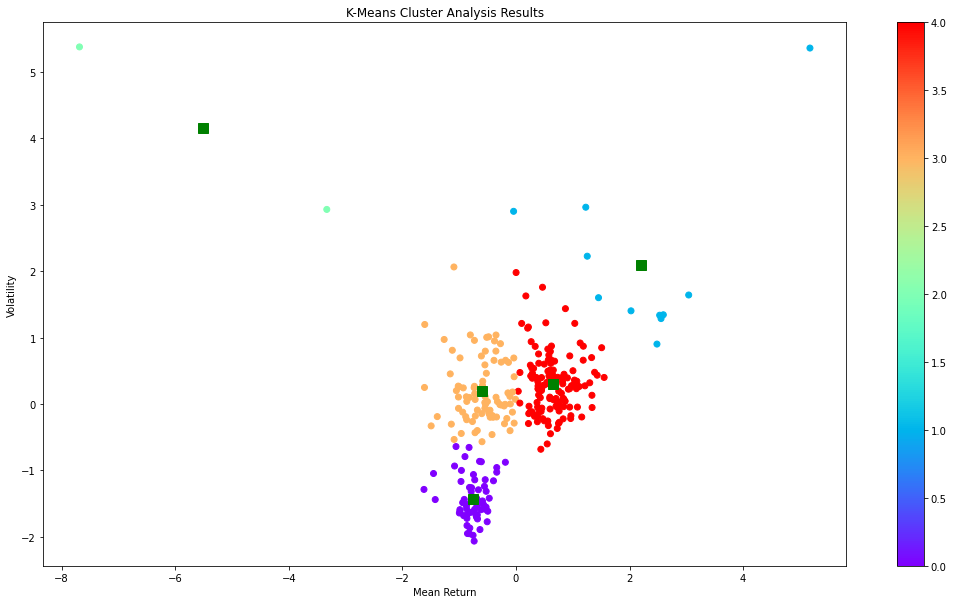

In [58]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [59]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series[:5]

AADR    3
AAXJ    3
ACWI    4
ACWX    3
ADRE    3
dtype: int32

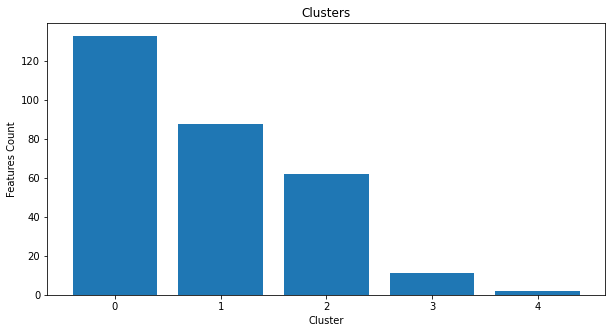

In [60]:
# View number by cluster
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [74]:
# Remove Items if Preferred
clusters_clean = clustered_series[clustered_series < 4]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))

Feature Number Previous:  296
Feature Number Current:  163


### Calculate Cointegration

In [75]:
# Calculate cointegration
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, sm.add_constant(series_2)).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio

In [77]:
# Loop through and calculate cointegrated pairs
# Allow 10 - 30 mins for calculation 
tested_pairs = []
cointegrated_pairs = []

for base_asset in clusters_clean.index:
    base_label = clusters_clean[base_asset]       

    for compare_asset in clusters_clean.index:
        compare_label = clusters_clean[compare_asset]
        
        test_pair = base_asset + compare_asset
        test_pair = ''.join(sorted(test_pair))
        is_tested = test_pair in tested_pairs
        tested_pairs.append(test_pair)
        
        if compare_asset != base_asset and base_label == compare_label and not is_tested:
            
            series_1 = data[base_asset].values.astype(float)
            series_2 = data[compare_asset].values.astype(float)
            coint_flag, _ = calculate_cointegration(series_1, series_2)
            if coint_flag == 1:
                cointegrated_pairs.append({"base_asset": base_asset, 
                                            "compare_asset": compare_asset, 
                                            "label": base_label})
                
df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    

In [78]:
pd.set_option('display.max_rows', None)
df_coint.head()

,base_asset,compare_asset,label
210,VRIG,VTIP,0
160,IGIB,VGSH,0
70,EMCB,VGSH,0
69,EMCB,SHY,0
68,EMCB,MFLX,0


### TSNE Plot for Visualization

In [79]:
# Get unique list of cointegrated assets
coint_assets = [df_coint["base_asset"].values]
coint_assets.append(df_coint["compare_asset"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AADR', 'AAXJ', 'ACWX', 'ADRE', 'AGZD'], dtype=object)

In [80]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility
AADR,-1.001303,0.258863
AAXJ,-0.874219,0.108567
ACWX,-0.469682,-0.153956
ADRE,-0.521789,0.462228
AGZD,-0.677318,-1.729253


In [81]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

array([[  1.4714128, -20.276548 ],
       [  3.818644 , -15.590678 ],
       [ 16.562008 ,   9.992011 ],
       [ 18.957314 , -19.203743 ],
       [-40.53027  ,  22.61679  ]], dtype=float32)

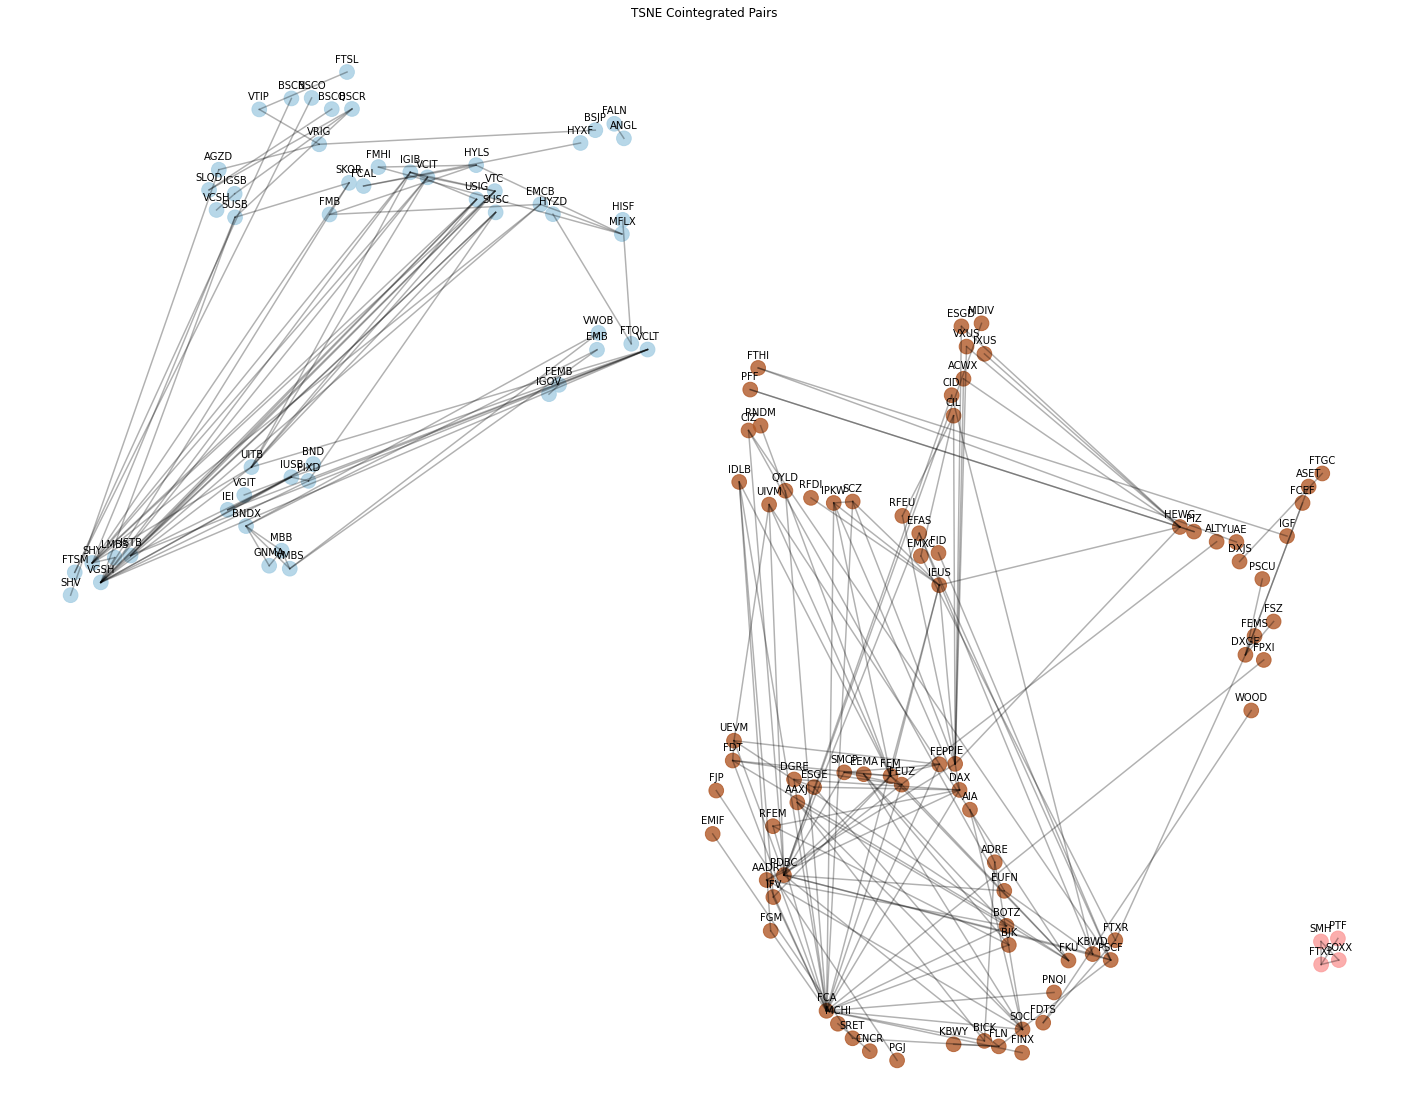

In [82]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()

### Review a Pair for exmaple

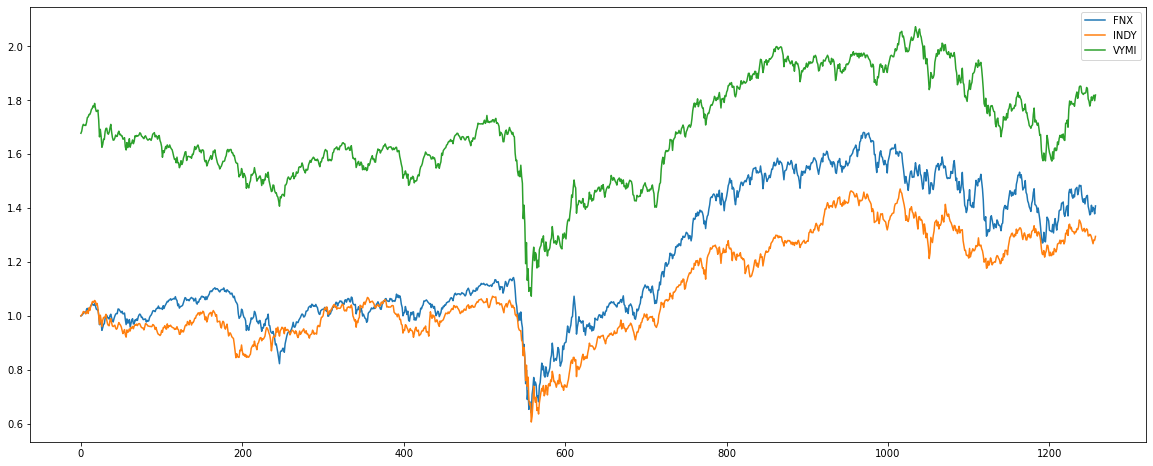

In [83]:
# Plot price comparison for any given assets
asset_1 = "FNX"
asset_2 = "INDY"
asset_3 = "VYMI"
# cumulative returns
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()
asset_3_values = data[asset_3].values / data[asset_2].iloc[0].item()
plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values, label = asset_1)
plt.plot(asset_2_values, label = asset_2)
plt.plot(asset_3_values, label = asset_3)
plt.legend()
plt.show()


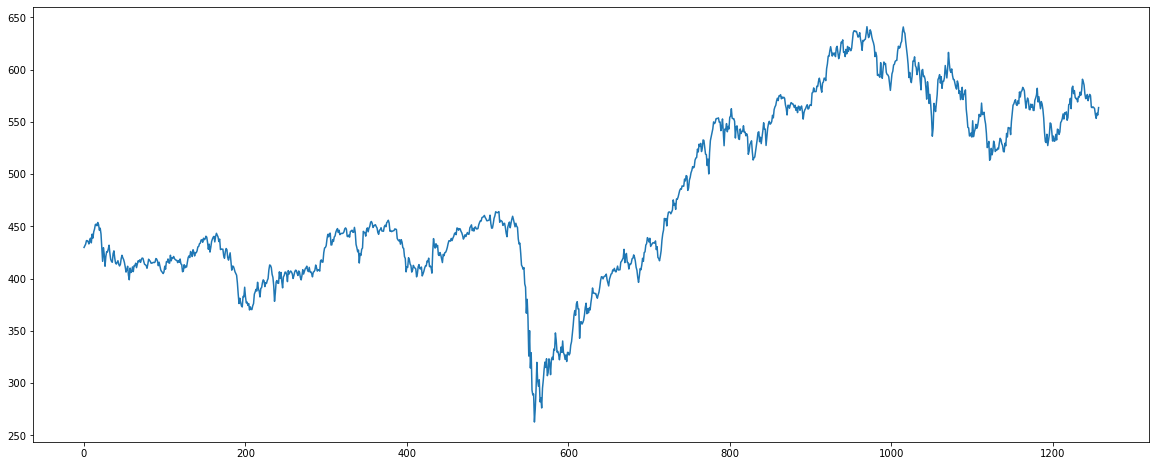

In [84]:
# Plot the Spread between FNX and INDY
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)
plt.figure(1, figsize=(20, 8))
plt.plot(spread)
plt.show()

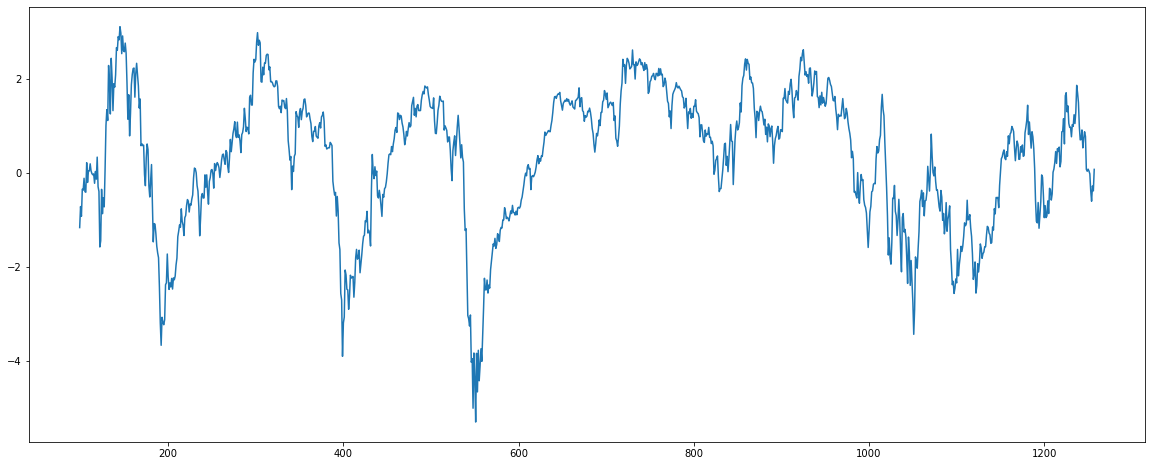

In [85]:
# Plot the ZScore
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std
plt.figure(1, figsize=(20, 8))
plt.plot(z_score)
plt.show()

### Save Data

In [86]:
# Save Data
capped = []
for z in z_score:
    z = 6 if z > 6 else z
    z = -6 if z <-6 else z
    capped.append(z)
df_save = data[[asset_1, asset_2]].copy()
df_save["Spread"] = spread
df_save["ZScore"] = capped
df_save.dropna(inplace=True)
df_save.columns = ["Asset1", "Asset2", "Spread", "ZScore"]
df_save.to_csv("data/pair_trade.csv")
df_save.tail()

,Asset1,Asset2,Spread,ZScore
Date,,,,
2022-12-22 00:00:00,86.952003,42.299999,556.974212,-0.380804
2022-12-23 00:00:00,87.970001,41.880001,553.325342,-0.603135
2022-12-27 00:00:00,87.610001,42.360001,558.298922,-0.278885
2022-12-28 00:00:00,86.440002,42.310001,556.573351,-0.383432
2022-12-29 00:00:00,88.290001,42.779999,563.645789,0.074024


### Conclusion

When sifting through heavy amounts of price data, it can be tricky to find potentially great pairs to trade quickly. Equally, having pairs which match likeness in terms of price behaviour including volatility, might be advantageous and ensure better risk management.

By clustering using K-Means, it's possible to quickly identify a list of trading pairs which resemble a likeness in respect to returns versus volatility. Helping to refine our conintegrated statistical arbitrage trading strategy even further.

Potenetial next step is to automate the hunt for potentially great trading opportunities.